In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from PIL import Image

In [3]:
import numpy as np

In [4]:
import os
from glob import glob

In [5]:
from sklearn.metrics import confusion_matrix

In [6]:
import shutil

In [7]:
import sys

In [8]:
def get_image_paths(data_path, categories, num_train_per_cat):
    num_categories = len(categories)

    train_image_paths = []
    test_image_paths = []

    train_labels = []
    test_labels = []

    for category in categories:

        image_paths = glob(os.path.join(data_path, 'train', category, '*.jpg'))
        
        for i in range(num_train_per_cat):
            train_image_paths.append(image_paths[i])
            train_labels.append(category)

        image_paths = glob(os.path.join(data_path, 'test', category, '*.jpg'))
        for i in range(num_train_per_cat):
            test_image_paths.append(image_paths[i])
            test_labels.append(category)

    return train_image_paths, test_image_paths, train_labels, test_labels

In [9]:
def get_tiny_images(image_paths):
    
    height = 16
    width = 16
    
    tiny_images = np.zeros((len(image_paths), width*height))
    
    for i, image_data in enumerate(image_paths):
        
        image = Image.open(image_data)
        image_re = np.asarray(image.resize((width,height), Image.ANTIALIAS), dtype = 'float32').flatten()
        image_nm = (image_re - np.mean(image_re))/np.std(image_re)
        tiny_images[i,:] = image_nm
        
    return tiny_images

In [10]:
DATA_PATH = 'C:\\Users\\white power\\Desktop\\test_python\\SceneDataset\\'

In [11]:
CATEGORIES = ['Kitchen', 'Bedroom', 'LivingRoom', 'Office', 'Highway', 'Mountain']

In [12]:
ABBR_CATEGORIES = ['Kit', 'Bed', 'Liv', 'Off', 'HW', 'Mnt']

In [13]:
NUM_TRAIN_PER_CAT = 100

In [14]:
CATE2ID = {v: k for k, v in enumerate(CATEGORIES)}

In [15]:
train_image_paths, test_image_paths, train_labels, test_labels = get_image_paths(DATA_PATH, CATEGORIES, NUM_TRAIN_PER_CAT)

create Tiny Image features here. 


In [16]:
train_image_feats = get_tiny_images(train_image_paths)
test_image_feats = get_tiny_images(test_image_paths)

The K-Nearest Neighbour classifier 

In [17]:
import scipy.spatial.distance as distance
import operator

def nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats):
    k = 13
    test_predicts = []
    dist = distance.cdist(train_image_feats, test_image_feats, 'euclidean')
    
    for i in range(dist.shape[1]):
        ans = np.argsort(dist[:,i])
        nn = dict()
        #print(ans)
        for j in range(k):
            if train_labels[ans[j]] in nn.keys():
                nn[train_labels[ans[j]]] += 1
            else :
                nn[train_labels[ans[j]]] = 1
 
        snn = sorted(nn.items(), key = operator.itemgetter(1), reverse=True)
        test_predicts.append(snn[0][0])
    
    return test_predicts

The SVM classifier 

In [18]:
from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

def svm_classify(train_image_feats, train_labels, test_image_feats):
    svc = SVC(random_state=0)
    param_C = [0.001 , 0.01 , 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
    param_gamma = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
    param_grid = [{'C': param_C,
                   'gamma': param_gamma,
                   'kernel': ['rbf']}]

    gs = GridSearchCV(estimator = svc,
                      param_grid= param_grid,
                      scoring='accuracy',
                     )
    
    gs = gs.fit(train_image_feats, train_labels)
        
    classifier = gs.best_estimator_
    classifier.fit(train_image_feats, train_labels)
    
    
    pred_label = classifier.predict(test_image_feats)
    return pred_label

Compute and plot confusion matrix, utility functions 

In [19]:
def plot_confusion_matrix(cm, category, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(category))
    plt.xticks(tick_marks, category, rotation=45)
    plt.yticks(tick_marks, category)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [20]:
def build_confusion_mtx(test_labels_ids, predicted_categories, abbr_categories):

    cm = confusion_matrix(test_labels_ids, predicted_categories)
    np.set_printoptions(precision=2)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plot_confusion_matrix(cm_normalized, abbr_categories, title='Normalized confusion matrix')

    plt.show()

Utility function for examining results on some images

In [21]:
def examine_induvidual_images(CATEGORIES, test_image_paths, test_labels_ids, predicted_categories_ids, train_labels_paths, train_labels_ids):
    
    FN_name = [None] * len(CATEGORIES)
    TP_name = [None] * len(CATEGORIES)
    FP_name = [None] * len(CATEGORIES)
    Train_name = [None] * len(CATEGORIES)
    
    print('Examining some of the results \n') 

    for k, name in enumerate(CATEGORIES):
        train_id = np.where(np.array(train_labels_ids) == k)[0].tolist()
        Train_name[k] = train_labels_paths[train_id[0]]
        instance_id = np.where(np.array(test_labels_ids) == k)
        instance_id = instance_id[0].tolist()
        instance_name = [test_image_paths[x] for x in instance_id]
        result = [predicted_categories_ids[x] for x in instance_id]
        for sub_id, sub_pred in enumerate(result):
            if sub_pred != k:
                FN_name[k] = instance_name[sub_id]
            elif sub_pred == k:
                TP_name[k] = instance_name[sub_id]

        pred_instance_id = np.where(np.array(predicted_categories_ids) == k)
        pred_instance_id = pred_instance_id[0].tolist()
        pred_instance_name = [test_image_paths[x] for x in pred_instance_id]
        pred_result = [test_labels_ids[x] for x in pred_instance_id]
        for sub_id, sub_pred in enumerate(pred_result):
            if sub_pred != k:
                FP_name[k] = pred_instance_name[sub_id]
        #print( '_train_' + Train_name[k])
        print( 'True Positive: ' + TP_name[k])
        print( 'False Positive: ' + FP_name[k])
        print( 'False Negative: ' + FN_name[k])
        print('\n')


Train and test an K-Nearest Neighbour classifier using the Tiny image features 

In [22]:
predicted_categories = nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats)

calculate accuracy of the nearest neighbour classifier using Tiny image features 

In [23]:
accuracy = float(len([x for x in zip(test_labels,predicted_categories) if x[0]== x[1]]))/float(len(test_labels))
print("Accuracy of the nearest neighbour classifier using Tiny image features is ", accuracy)
test_labels_ids = [CATE2ID[x] for x in test_labels]
predicted_categories_ids = [CATE2ID[x] for x in predicted_categories]
train_labels_ids = [CATE2ID[x] for x in train_labels]

Accuracy of the nearest neighbour classifier using Tiny image features is  0.3933333333333333


plot confusion matrix for this model

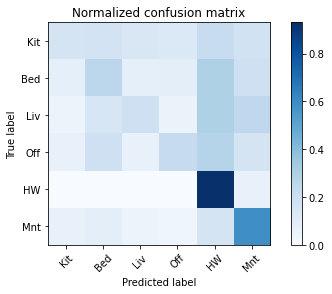

In [24]:
build_confusion_mtx(test_labels_ids, predicted_categories_ids, ABBR_CATEGORIES)

Examine the results on some images 

In [25]:
examine_induvidual_images(CATEGORIES, test_image_paths, test_labels_ids, predicted_categories_ids, train_image_paths, train_labels_ids)

Examining some of the results 

True Positive: C:\Users\white power\Desktop\test_python\SceneDataset\test\Kitchen\963.jpg
False Positive: C:\Users\white power\Desktop\test_python\SceneDataset\test\Mountain\2723.jpg
False Negative: C:\Users\white power\Desktop\test_python\SceneDataset\test\Kitchen\968.jpg


True Positive: C:\Users\white power\Desktop\test_python\SceneDataset\test\Bedroom\197.jpg
False Positive: C:\Users\white power\Desktop\test_python\SceneDataset\test\Mountain\2708.jpg
False Negative: C:\Users\white power\Desktop\test_python\SceneDataset\test\Bedroom\200.jpg


True Positive: C:\Users\white power\Desktop\test_python\SceneDataset\test\LivingRoom\1177.jpg
False Positive: C:\Users\white power\Desktop\test_python\SceneDataset\test\Mountain\2698.jpg
False Negative: C:\Users\white power\Desktop\test_python\SceneDataset\test\LivingRoom\1178.jpg


True Positive: C:\Users\white power\Desktop\test_python\SceneDataset\test\Office\4152.jpg
False Positive: C:\Users\white power\Deskt

Train and test an SVM classifier using the Tiny image features 

In [26]:
predicted_categories = svm_classify(train_image_feats, train_labels, test_image_feats)

As we calculate the  accuracy of the nearest neighbour classifier using Tiny image features, now we will calculate the accuracy of the SVM classifier using Tiny image features

In [27]:
accuracy = float(len([x for x in zip(test_labels,predicted_categories) if x[0]== x[1]]))/float(len(test_labels))
print("Accuracy of the SVM classifier using Tiny image features is ", accuracy)
test_labels_ids = [CATE2ID[x] for x in test_labels]
predicted_categories_ids = [CATE2ID[x] for x in predicted_categories]
train_labels_ids = [CATE2ID[x] for x in train_labels]

Accuracy of the SVM classifier using Tiny image features is  0.41833333333333333


plot confusion matrix for this model

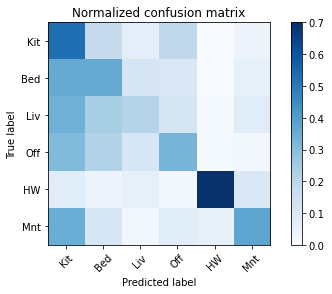

In [28]:
build_confusion_mtx(test_labels_ids, predicted_categories_ids, ABBR_CATEGORIES)

Examine the results on some images 

In [29]:
examine_induvidual_images(CATEGORIES, test_image_paths, test_labels_ids, predicted_categories_ids, train_image_paths, train_labels_ids)

Examining some of the results 

True Positive: C:\Users\white power\Desktop\test_python\SceneDataset\test\Kitchen\968.jpg
False Positive: C:\Users\white power\Desktop\test_python\SceneDataset\test\Mountain\2723.jpg
False Negative: C:\Users\white power\Desktop\test_python\SceneDataset\test\Kitchen\966.jpg


True Positive: C:\Users\white power\Desktop\test_python\SceneDataset\test\Bedroom\198.jpg
False Positive: C:\Users\white power\Desktop\test_python\SceneDataset\test\Mountain\2720.jpg
False Negative: C:\Users\white power\Desktop\test_python\SceneDataset\test\Bedroom\200.jpg


True Positive: C:\Users\white power\Desktop\test_python\SceneDataset\test\LivingRoom\1176.jpg
False Positive: C:\Users\white power\Desktop\test_python\SceneDataset\test\Mountain\2722.jpg
False Negative: C:\Users\white power\Desktop\test_python\SceneDataset\test\LivingRoom\1178.jpg


True Positive: C:\Users\white power\Desktop\test_python\SceneDataset\test\Office\4154.jpg
False Positive: C:\Users\white power\Deskt

In the following, we will assess the performance of the bag of SIFT features using KNN and SVM classifiers. 

First, we will extract the SIFT features. 

We will use and call SIFT implementaion from the cyvlfeat library. 

In [30]:
from cyvlfeat.sift.dsift import dsift
from cyvlfeat.kmeans import kmeans

def build_vocabulary(image_paths, vocab_size):
   
    bag_of_features = []
    
    for path in image_paths:
        img = np.asarray(Image.open(path),dtype='float32')
        frames, descriptors = dsift(img, step=[5,5], fast=True)
        bag_of_features.append(descriptors)
    bag_of_features = np.concatenate(bag_of_features, axis=0).astype('float32')
    vocab = kmeans(bag_of_features, vocab_size, initialization="PLUSPLUS")        

    return vocab

In [31]:
vocab_size = 400   ### Vocab_size is up to you. Larger values will work better (to a point) but be slower to comput.
vocab = build_vocabulary(train_image_paths, vocab_size)

In [32]:
from scipy.spatial import distance
import scipy.spatial.distance as distance
from cyvlfeat.sift.dsift import dsift

def get_bags_of_sifts(image_paths, vocab):
    
    image_feats = np.zeros((len(train_image_paths),len(vocab)))            
    
    for i, path in enumerate(image_paths):
        
        image = np.asarray(Image.open(path), dtype = 'float32')
        frames, descriptors = dsift(image, step=[9,9], fast=True)
        
        dist = distance.cdist(vocab, descriptors, 'euclidean')
        mdist = np.argmin(dist, axis = 0)
        histo, bins = np.histogram(mdist, range(len(vocab)+1))
        if np.linalg.norm(histo) == 0:
            image_feats[i, :] = histo
        else:
            image_feats[i, :] = histo / np.linalg.norm(histo)
    return image_feats

In [33]:
train_image_feats = get_bags_of_sifts(train_image_paths, vocab);

In [34]:
test_image_feats  = get_bags_of_sifts(test_image_paths, vocab);

Now, we will use the SIFT features to train and test an SVM classifier 

In [35]:
predicted_categories = svm_classify(train_image_feats, train_labels, test_image_feats)

Similar to the previous sections, we will report the accuracy of the SVM classifier using the SIFT features in the following.

In [36]:
accuracy = float(len([x for x in zip(test_labels,predicted_categories) if x[0]== x[1]]))/float(len(test_labels))
print("Accuracy of the SVM classifier using SIFT features is ", accuracy)
test_labels_ids = [CATE2ID[x] for x in test_labels]
predicted_categories_ids = [CATE2ID[x] for x in predicted_categories]
train_labels_ids = [CATE2ID[x] for x in train_labels]

Accuracy of the SVM classifier using SIFT features is  0.6816666666666666


plot confusion matrix for this model

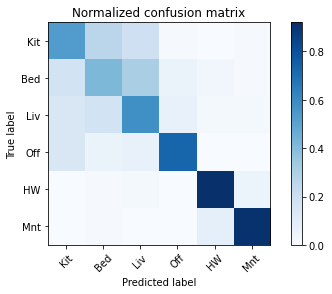

In [37]:
build_confusion_mtx(test_labels_ids, predicted_categories_ids, ABBR_CATEGORIES)

Examine the results on some images 

In [38]:
examine_induvidual_images(CATEGORIES, test_image_paths, test_labels_ids, predicted_categories_ids, train_image_paths, train_labels_ids)

Examining some of the results 

True Positive: C:\Users\white power\Desktop\test_python\SceneDataset\test\Kitchen\967.jpg
False Positive: C:\Users\white power\Desktop\test_python\SceneDataset\test\Office\4155.jpg
False Negative: C:\Users\white power\Desktop\test_python\SceneDataset\test\Kitchen\968.jpg


True Positive: C:\Users\white power\Desktop\test_python\SceneDataset\test\Bedroom\196.jpg
False Positive: C:\Users\white power\Desktop\test_python\SceneDataset\test\Mountain\2669.jpg
False Negative: C:\Users\white power\Desktop\test_python\SceneDataset\test\Bedroom\200.jpg


True Positive: C:\Users\white power\Desktop\test_python\SceneDataset\test\LivingRoom\1177.jpg
False Positive: C:\Users\white power\Desktop\test_python\SceneDataset\test\Highway\2124.jpg
False Negative: C:\Users\white power\Desktop\test_python\SceneDataset\test\LivingRoom\1178.jpg


True Positive: C:\Users\white power\Desktop\test_python\SceneDataset\test\Office\4154.jpg
False Positive: C:\Users\white power\Desktop\

Finally, we will use the SIFT features in the  KNN classifier 

In [39]:
predicted_categories = nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats)

Similar to the previous sections, we will report the accuracy of the KNN clasifier using the SIFT features in the following. 

In [40]:
accuracy = float(len([x for x in zip(test_labels,predicted_categories) if x[0]== x[1]]))/float(len(test_labels))
print("Accuracy of the KNN classifier using SIFT features is ", accuracy)
test_labels_ids = [CATE2ID[x] for x in test_labels]
predicted_categories_ids = [CATE2ID[x] for x in predicted_categories]
train_labels_ids = [CATE2ID[x] for x in train_labels]

Accuracy of the KNN classifier using SIFT features is  0.6


plot confusion matrix for this model

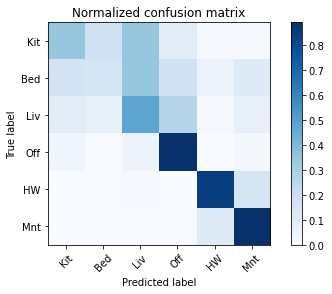

In [41]:
build_confusion_mtx(test_labels_ids, predicted_categories_ids, ABBR_CATEGORIES)

Examine the results on some images 

In [42]:
examine_induvidual_images(CATEGORIES, test_image_paths, test_labels_ids, predicted_categories_ids, train_image_paths, train_labels_ids)

Examining some of the results 

True Positive: C:\Users\white power\Desktop\test_python\SceneDataset\test\Kitchen\967.jpg
False Positive: C:\Users\white power\Desktop\test_python\SceneDataset\test\Office\4131.jpg
False Negative: C:\Users\white power\Desktop\test_python\SceneDataset\test\Kitchen\968.jpg


True Positive: C:\Users\white power\Desktop\test_python\SceneDataset\test\Bedroom\196.jpg
False Positive: C:\Users\white power\Desktop\test_python\SceneDataset\test\LivingRoom\1147.jpg
False Negative: C:\Users\white power\Desktop\test_python\SceneDataset\test\Bedroom\200.jpg


True Positive: C:\Users\white power\Desktop\test_python\SceneDataset\test\LivingRoom\1177.jpg
False Positive: C:\Users\white power\Desktop\test_python\SceneDataset\test\Highway\2124.jpg
False Negative: C:\Users\white power\Desktop\test_python\SceneDataset\test\LivingRoom\1178.jpg


True Positive: C:\Users\white power\Desktop\test_python\SceneDataset\test\Office\4155.jpg
False Positive: C:\Users\white power\Deskto